In [1]:
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [2]:
# Load histories
uv = np.load('uv_history.npy')
c_pose = np.load('c_pose_history.npy')
vel = np.load('vel_history.npy')

In [3]:
# Check array shapes
print('uv shape:', uv.shape)
print('c_pose shape:', c_pose.shape)
print('vel shape:', vel.shape)

uv shape: (83, 2, 4)
c_pose shape: (82, 4, 4)
vel shape: (83, 4, 4)


In [13]:
def plot_feature_trajectory(uv_history, camera_pose_history, T_delta_history, camera_width, camera_height):
    """
    Plot feature trajectory from simulation

    Show image feature points versus time.
    """

    if len(uv_history) == 0 or len(camera_pose_history) == 0 or len(T_delta_history) == 0:
        return

    # Extract the number of feature points
    npoints = uv_history.shape[2]

    # Plot the trajectory for each feature point
    for i in range(npoints):
        u = uv_history[:, 0, i]  # get u data for i'th point
        v = uv_history[:, 1, i]  # get v data for i'th point
        plt.plot(u, v, "b")

    # Mark the initial position of the feature points
    plt.plot(uv_history[0, 0, :], uv_history[0, 1, :], "o--", markeredgecolor="k", markerfacecolor="w", label="initial")

    # Mark the final position of the feature points
    plt.plot(uv_history[-1, 0, :], uv_history[-1, 1, :], "k*:", markeredgecolor="k", markerfacecolor="k", label="final")

    plt.grid(True)
    plt.xlabel("u (pixels)")
    plt.ylabel("v (pixels)")
    plt.xlim(0, camera_width)
    plt.ylim(0, camera_height)
    plt.legend()
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_facecolor("lightyellow")
    plt.show()

# Assuming uv_history, camera_pose_history, and T_delta_history are given with appropriate shapes
camera_width = 640  # example value, set according to your camera specifications
camera_height = 480  # example value, set according to your camera specifications


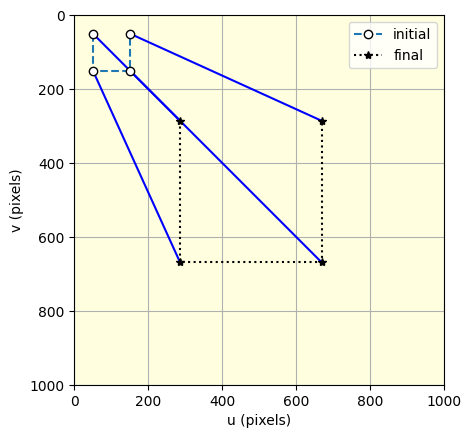

In [14]:
plot_feature_trajectory(uv, c_pose, vel, 1000, 1000)

In [20]:
def plot_vel(history_vel):
    """
    Plot camera velocity from simulation

    Show camera velocity versus time.
    """
    if len(history_vel) == 0:
        return

    # Convert history to numpy array
    vel = np.array(history_vel)  # Shape (83, 4, 4)

    # Extract translational velocities (v_x, v_y, v_z)
    translational_vel = vel[:, :3, 3]  # Shape (83, 3)

    # Extract rotational velocities (omega_x, omega_y, omega_z)
    rotational_vel = vel[:, :3, :3]  # Shape (83, 3, 3)

    # For simplicity, we might want to plot the rotational velocities as norms
    rotational_norms = np.linalg.norm(rotational_vel, axis=(1, 2))  # Shape (83,)

    # Plot translational velocities
    plt.figure(figsize=(10, 5))
    plt.plot(translational_vel[:, 0], "-", label="$v_x$")
    plt.plot(translational_vel[:, 1], "-", label="$v_y$")
    plt.plot(translational_vel[:, 2], "-", label="$v_z$")

    # Plot rotational velocities
    plt.plot(rotational_norms, "--", label=r"$\omega$")

    plt.ylabel("Cartesian velocity")
    plt.xlabel("Time step")
    plt.xlim(0, len(history_vel) - 1)
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.title("Camera Velocity vs Time")
    plt.show()

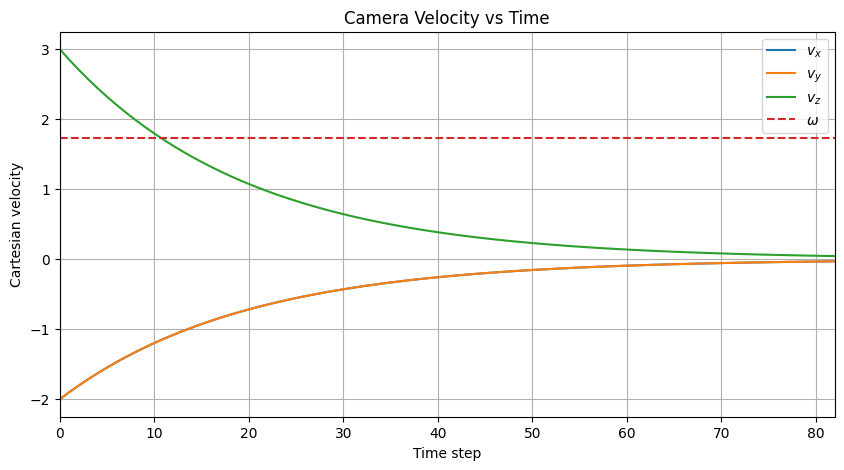

In [21]:
plot_vel(vel)

In [22]:
def plot_pose(c_pose_history):
    """
    Plot camera trajectory from simulation

    Show camera pose versus time, as two plots: translation and rotation
    in RPY angles.

    :seealso: :meth:`plot_p` :meth:`self.plot_vel` :meth:`plot_jcond` :meth:`plot_z` :meth:`plot_error`
    """

    if len(c_pose_history) == 0:
        return

    # Extract translations (x, y, z) and rotations (RPY) from the c_pose history
    translations = np.array([pose[:3, 3] for pose in c_pose_history])
    rotations = np.array([R.from_matrix(pose[:3, :3]).as_euler('xyz', degrees=False) for pose in c_pose_history])

    plt.figure(figsize=(12, 6))

    # Cartesian camera position vs timestep
    plt.subplot(211)
    plt.plot(translations)
    plt.xlim(0, len(c_pose_history) - 1)
    plt.ylabel("Camera position (m)")
    plt.legend(["x", "y", "z"])
    plt.grid(True)

    # Camera orientation (RPY) vs timestep
    plt.subplot(212)
    plt.plot(rotations)
    plt.ylabel("Camera orientation (rad)")
    plt.xlabel("Time step")
    plt.xlim(0, len(c_pose_history) - 1)
    plt.legend([r"$\alpha$", r"$\beta$", r"$\gamma$"])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

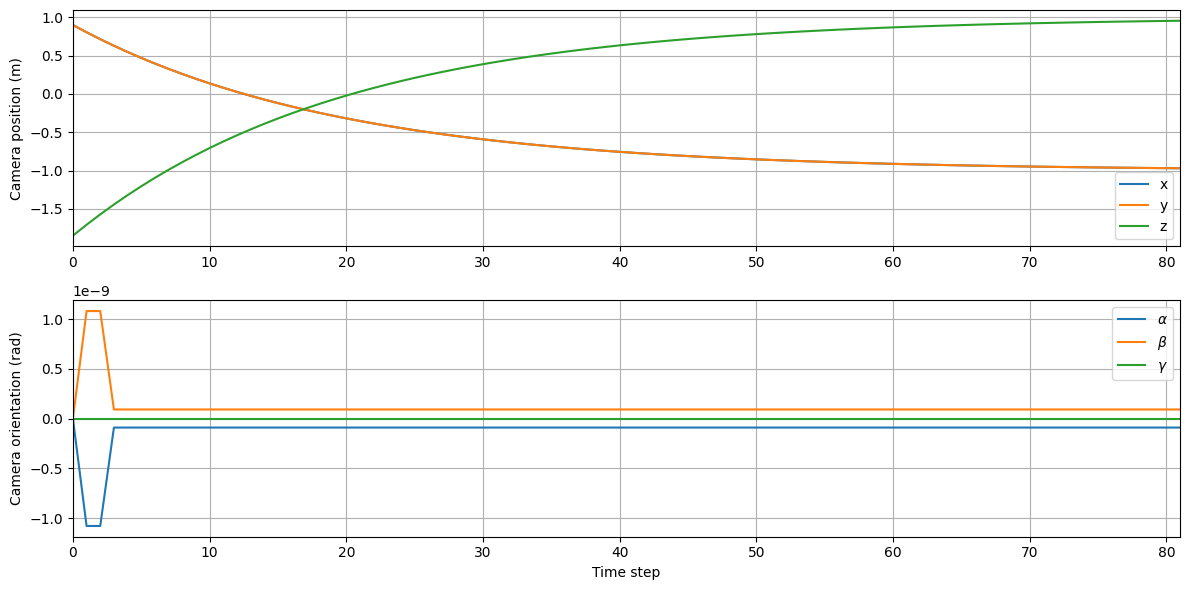

In [23]:
plot_pose(c_pose)